<a href="https://colab.research.google.com/github/anhduong77/Wildfire_Assessment_Via_Remote_Sensing/blob/main/notebook/2_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Split data
- Since data have a severe unbalance we need to ensure that both train and test set owning approximately the same proportion between forest / non-forest pixels

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install rasterio -q > /dev/null
import rasterio
import numpy as np
import glob

flt_mask_files = sorted(glob.glob("/content/drive/MyDrive/EarthEngine/filtered_patches/mask_*.tif"))

burned_area_ratios = []
for mf in flt_mask_files:
    with rasterio.open(mf) as src:
        mask = src.read(1)
        total = mask.size
        burned_area = np.sum(mask > 0)  # assuming >0 means forest
        burned_area_ratios.append(burned_area / total)

# Pair image + mask with its forest ratio
flt_tiles = list(zip(sorted(glob.glob("/content/drive/MyDrive/EarthEngine/filtered_patches/img_*.tif")),
                 flt_mask_files,
                 burned_area_ratios))

scaled_mask_files = sorted(glob.glob("/content/drive/MyDrive/EarthEngine/scale_patches/mask_*.tif"))

burned_area_ratios_2 = []
for mf in flt_mask_files:
    with rasterio.open(mf) as src:
        mask = src.read(1)
        total = mask.size
        burned_area = np.sum(mask > 0)  # assuming >0 means forest
        burned_area_ratios_2.append(burned_area / total)

# Pair image + mask with its forest ratio
scaled_tiles = list(zip(sorted(glob.glob("/content/drive/MyDrive/EarthEngine/scale_patches/img_*.tif")),
                 scaled_mask_files,
                 burned_area_ratios_2))



/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
from sklearn.model_selection import train_test_split

# Convert forest ratio into binary "has forest or not"
flt_labels = [1 if r > 0.05 else 0 for _,_,r in flt_tiles]  # threshold at 5%

flt_train_tiles, flt_test_tiles = train_test_split(
    flt_tiles, test_size=0.2, stratify=flt_labels, random_state=42
)


scaled_labels = [1 if r > 0.05 else 0 for _,_,r in scaled_tiles]  # threshold at 5%

scaled_train_tiles, scaled_test_tiles = train_test_split(
    scaled_tiles, test_size=0.2, stratify=scaled_labels, random_state=42
)


In [ ]:
flt_train_imgs = [t[0] for t in flt_train_tiles]
flt_train_masks = [t[1] for t in flt_train_tiles]

flt_test_imgs = [t[0] for t in flt_test_tiles]
flt_test_masks = [t[1] for t in flt_test_tiles]


scaled_train_imgs = [t[0] for t in scaled_train_tiles]
scaled_train_masks = [t[1] for t in scaled_train_tiles]


scaled_test_imgs = [t[0] for t in scaled_test_tiles]
scaled_test_masks = [t[1] for t in scaled_test_tiles]


# Modeling

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
import tifffile as tiff
import torch
import numpy as np

class SatelliteDataset(Dataset):
    def __init__(self, image_files, mask_files, size=128):
        self.image_files = image_files
        self.mask_files = mask_files
        self.size = size
        # Only for images
        self.transform_img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((size, size), antialias=True)
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = tiff.imread(self.image_files[idx])
        mask = tiff.imread(self.mask_files[idx])

        # Handle image shape
        if img.ndim == 3 and img.shape[0] <= 4:
            img = np.transpose(img, (1, 2, 0))
        img = self.transform_img(img.astype(np.float32))

        # Process mask (force 0/1, no normalization)
        mask[mask > 0] = 1
        mask = mask.astype(np.uint8)

        mask = torch.from_numpy(mask)
        mask = TF.resize(mask.unsqueeze(0), (self.size, self.size), interpolation=transforms.InterpolationMode.NEAREST)
        mask = mask.squeeze(0).long()

        return img, mask

In [ ]:
from torch.utils.data import DataLoader

flt_train_dataset = SatelliteDataset(flt_train_imgs, flt_train_masks, size=128)
flt_test_dataset = SatelliteDataset(flt_test_imgs, flt_test_masks, size=128)
flt_train_loader = DataLoader(flt_train_dataset,  batch_size=8, shuffle=True)
flt_test_loader = DataLoader(flt_test_dataset, batch_size=8, shuffle=True)

scaled_train_dataset = SatelliteDataset(scaled_train_imgs, scaled_train_masks, size=128)
scaled_test_dataset = SatelliteDataset(scaled_test_imgs, scaled_test_masks, size=128)
scaled_train_loader = DataLoader(scaled_train_dataset,  batch_size=8, shuffle=True)
scaled_test_loader = DataLoader(scaled_test_dataset, batch_size=8, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(n_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.out(d1)


In [ ]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import jaccard_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pos_weight = torch.tensor([5.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
def evaluate_loss_and_iou(pred_logits, labels):
    # BCE loss
    loss = criterion(pred_logits, labels)

    # Convert logits → probabilities → binary predictions
    probs = torch.sigmoid(pred_logits)               # [B, 1, H, W]
    preds = (probs > 0.5).long()                     # [B, 1, H, W]

    # IoU calculation
    preds = preds.squeeze(1).cpu().numpy()           # [B, H, W]
    true_mask = labels.squeeze(1).cpu().numpy()      # [B, H, W]

    iou = jaccard_score(true_mask.flatten(), preds.flatten())

    return loss.item(), iou

In [ ]:
flt_model = UNet(n_channels=15, n_classes=1).to(device)
scaled_model = UNet(n_channels=15, n_classes=1).to(device)

flt_optimizer = optim.Adam(flt_model.parameters(), lr=0.001)
scaled_optimizer = optim.Adam(scaled_model.parameters(), lr=0.001)

In [ ]:
import torch.nn.functional as F
flt_test_loss, flt_test_iou = [], []
flt_model_eval = []
scaled_model_eval = []

best_flt_model = flt_model.state_dict()
best_scaled_model = scaled_model.state_dict()
flt_max_iou, scaled_max_iou = -10e8, -10e8

for epoch in range(1, 1000):  # try 10–20 first
  flt_model.train()
  scaled_model.train()
  epoch_loss = 0
  for (flt_imgs, flt_masks), (scaled_imgs, scaled_masks) in zip(flt_train_loader, scaled_train_loader):
      flt_imgs, flt_masks = flt_imgs.to(device), flt_masks.float().to(device)  # masks must be float
      scaled_imgs, scaled_masks = scaled_imgs.to(device), scaled_masks.float().to(device)

      flt_optimizer.zero_grad()
      scaled_optimizer.zero_grad()

      flt_outputs = flt_model(flt_imgs)
      scaled_outputs = scaled_model(scaled_imgs)
      flt_loss = criterion(flt_outputs.squeeze(1), flt_masks.squeeze(1))
      scaled_loss = criterion(scaled_outputs.squeeze(1), scaled_masks.squeeze(1))
      flt_loss.backward()
      scaled_loss.backward()
      flt_optimizer.step()
      scaled_optimizer.step()


  flt_model.eval()
  scaled_model.eval()
  with torch.no_grad():
    for (flt_imgs, flt_masks), (scaled_imgs, scaled_masks) in zip(flt_test_loader, scaled_test_loader):

        flt_imgs, flt_masks = flt_imgs.to(device), flt_masks.float().to(device)
        scaled_imgs, scaled_masks = scaled_imgs.to(device), scaled_masks.float().to(device)

        flt_outputs = flt_model(flt_imgs)  # logits
        scaled_outputs = scaled_model(scaled_imgs)
        flt_preds = torch.argmax(flt_outputs, dim=1)  # predicted masks
        scaled_preds = torch.argmax(scaled_outputs, dim=1)


        flt_loss, flt_iou = evaluate_loss_and_iou(flt_outputs.squeeze(1), flt_masks.squeeze(1))
        scaled_loss, scaled_iou = evaluate_loss_and_iou(scaled_outputs.squeeze(1), scaled_masks.squeeze(1))

        flt_model_eval.append({
            'test_loss': np.mean(flt_loss).tolist(),
            'test_iou': np.mean(flt_iou).tolist(),
        })
        if (flt_iou > flt_max_iou and flt_loss < 0.1):best_flt_model = flt_model.state_dict()
        if (scaled_iou > scaled_max_iou and scaled_loss < 0.1):best_scaled_model = scaled_model.state_dict()
        scaled_model_eval.append({
          'test_loss': np.mean(scaled_loss).tolist(),
          'test_iou': np.mean(scaled_iou).tolist(),
        })


In [ ]:
import pandas as pd
flt_df = pd.DataFrame(flt_model_eval)
scaled_df = pd.DataFrame(scaled_model_eval)

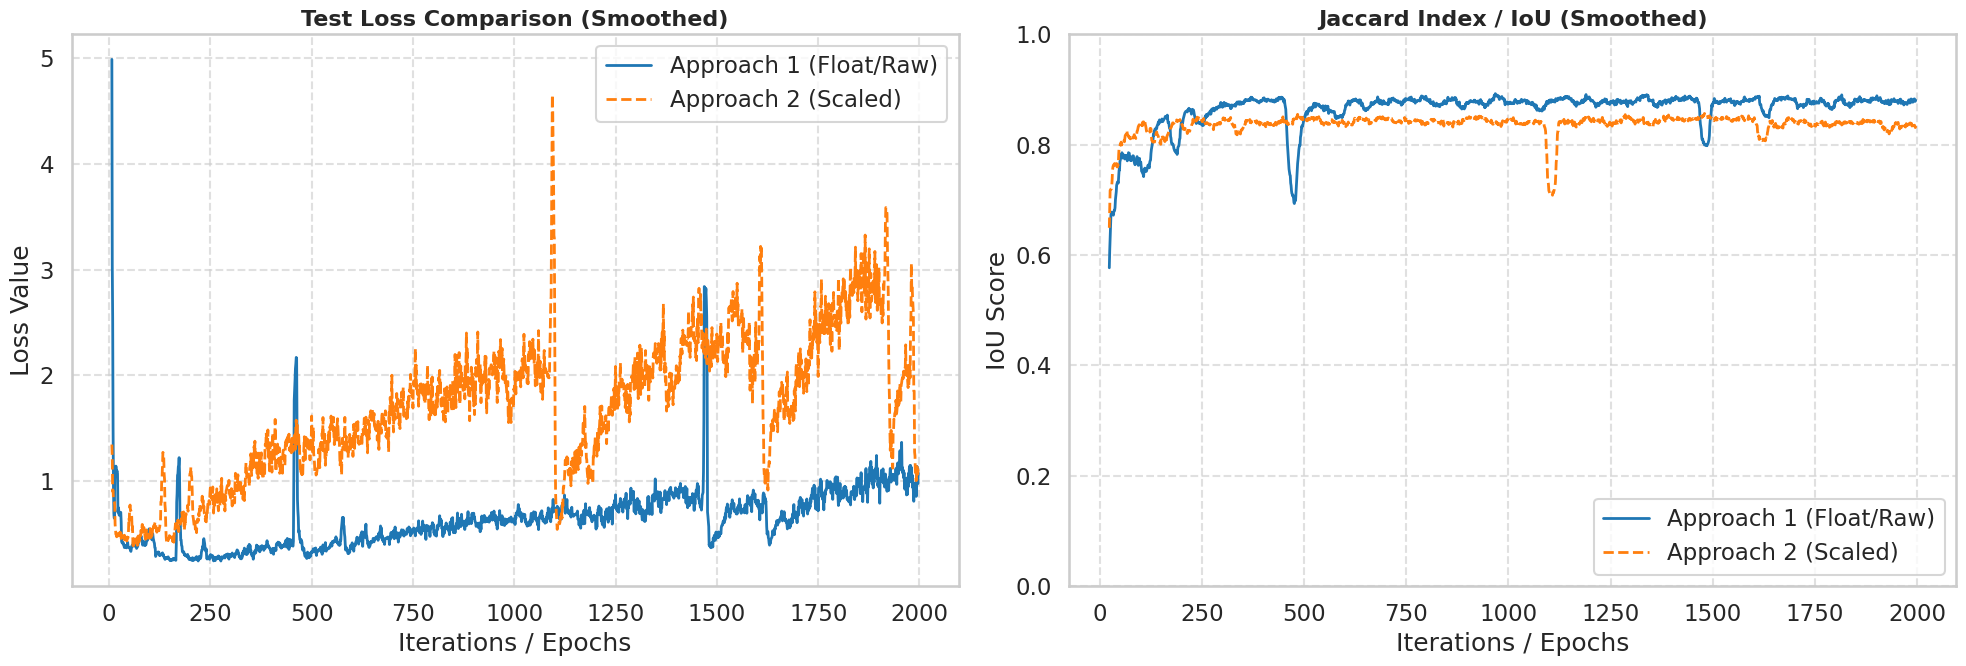

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but makes charts look much better instantly

# 1. Set a professional theme
sns.set_theme(style="whitegrid", context="talk")

f, axes = plt.subplots(1, 2, figsize=(20, 7))

# --- CHART 1: LOSS COMPARISON ---
# We use distinct colors and a slightly thicker line for visibility
axes[0].plot(flt_df['test_loss'].rolling(window=8).mean(),
             label='Approach 1 (Float/Raw)', color='#1f77b4', linewidth=2)
axes[0].plot(scaled_df['test_loss'].rolling(window=8).mean(),
             label='Approach 2 (Scaled)', color='#ff7f0e', linewidth=2, linestyle='--')

# Styling the Loss Chart
axes[0].set_title("Test Loss Comparison (Smoothed)", fontsize=16, weight='bold')
axes[0].set_ylabel("Loss Value")
axes[0].set_xlabel("Iterations / Epochs")
axes[0].legend(frameon=True)
axes[0].grid(True, linestyle='--', alpha=0.6)


# --- CHART 2: IoU COMPARISON ---
axes[1].plot(flt_df['test_iou'].rolling(window=24).mean(),
             label='Approach 1 (Float/Raw)', color='#1f77b4', linewidth=2)
axes[1].plot(scaled_df['test_iou'].rolling(window=24).mean(),
             label='Approach 2 (Scaled)', color='#ff7f0e', linewidth=2, linestyle='--')

# Styling the IoU Chart
axes[1].set_title("Jaccard Index / IoU (Smoothed)", fontsize=16, weight='bold')
axes[1].set_ylabel("IoU Score")
axes[1].set_xlabel("Iterations / Epochs")
axes[1].set_ylim(0, 1.0)  # Crucial: Locks the view to the valid 0-1 range
axes[1].legend(loc='lower right', frameon=True)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
flt_df.sort_values(by='test_iou', ascending=False, inplace=True)
scaled_df.sort_values(by='test_iou', ascending=False, inplace=True)

In [ ]:
print("========Selected model evaluation=======")
print("======First pre-processessing approach=======")
display(flt_df[flt_df['test_loss'] < 0.01])
print("======Second pre-processessing approach=======")
display(scaled_df[scaled_df['test_loss'] < 0.01])

========Selected model evaluation=======
======First pre-processessing approach=======


,test_loss,test_iou
1857,0.003879,0.997226
1963,0.004141,0.997698


======Second pre-processessing approach=======


,test_loss,test_iou


- No model in the second approach is selected in this part. It can demonstrate that the first approach of pre-processing is more effective.

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(24, 8))
axes[0].plot(scaled_df['test_loss'].rolling(window=8).mean())
axes[1].plot(scaled_df['test_iou'].rolling(window=24).mean())

- At the epoch 1293 for filtered_data, and 367 for scaled_data

Experiment 2: adding regulization penalty

In [ ]:
flt_model_2 = UNet(n_channels=15, n_classes=1).to(device)
scaled_model_2 = UNet(n_channels=15, n_classes=1).to(device)

flt_optimizer_2 = optim.Adam(flt_model_2.parameters(), lr=0.001, weight_decay=1e-5)
scaled_optimizer_2 = optim.Adam(scaled_model_2.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
import torch.nn.functional as F
flt_val_loss, flt_val_iou = [], []
flt_model_eval_2 = []
scaled_model_eval_2 = []

best_flt_model = flt_model_2.state_dict()
best_scaled_model = scaled_model_2.state_dict()
flt_max_iou, scaled_max_iou = -10e8, -10e8

for epoch in range(1, 1000):  # try 10–20 first
  flt_model_2.train()
  scaled_model_2.train()
  epoch_loss = 0
  for (flt_imgs, flt_masks), (scaled_imgs, scaled_masks) in zip(flt_train_loader, scaled_train_loader):
      flt_imgs, flt_masks = flt_imgs.to(device), flt_masks.float().to(device)  # masks must be float
      scaled_imgs, scaled_masks = scaled_imgs.to(device), scaled_masks.float().to(device)



      flt_outputs = flt_model_2(flt_imgs)
      scaled_outputs = scaled_model_2(scaled_imgs)
      flt_loss = criterion(flt_outputs.squeeze(1), flt_masks.squeeze(1))
      scaled_loss = criterion(scaled_outputs.squeeze(1), scaled_masks.squeeze(1))
      flt_loss.backward()
      scaled_loss.backward()
      flt_optimizer_2.step()
      scaled_optimizer_2.step()


  flt_model_2.eval()
  scaled_model_2.eval()
  with torch.no_grad():
    for (flt_imgs, flt_masks), (scaled_imgs, scaled_masks) in zip(flt_test_loader, scaled_test_loader):

        flt_imgs, flt_masks = flt_imgs.to(device), flt_masks.float().to(device)
        scaled_imgs, scaled_masks = scaled_imgs.to(device), scaled_masks.float().to(device)

        flt_outputs = flt_model_2(flt_imgs)  # logits
        scaled_outputs = scaled_model_2(scaled_imgs)
        flt_preds = torch.argmax(flt_outputs, dim=1)  # predicted masks
        scaled_preds = torch.argmax(scaled_outputs, dim=1)
        # # Convert to numpy for visualization
        # pred_np = preds.cpu().numpy()
        # mask_np = masks.cpu().numpy()

        flt_loss, flt_iou = evaluate_loss_and_iou(flt_outputs.squeeze(1), flt_masks.squeeze(1))
        scaled_loss, scaled_iou = evaluate_loss_and_iou(scaled_outputs.squeeze(1), scaled_masks.squeeze(1))

        flt_model_eval_2.append({
            'test_loss': np.mean(flt_loss).tolist(),
            'test_iou': np.mean(flt_iou).tolist(),
        })
        if (flt_iou > flt_max_iou and flt_loss < 0.1):best_flt_model = flt_model.state_dict()
        if (scaled_iou > scaled_max_iou and scaled_loss < 0.1):best_scaled_model = scaled_model.state_dict()
        scaled_model_eval_2.append({
          'test_loss': np.mean(scaled_loss).tolist(),
          'test_iou': np.mean(scaled_iou).tolist(),
        })


In [ ]:
import pandas as pd
flt_df = pd.DataFrame(flt_model_eval_2)
scaled_df = pd.DataFrame(scaled_model_eval_2)

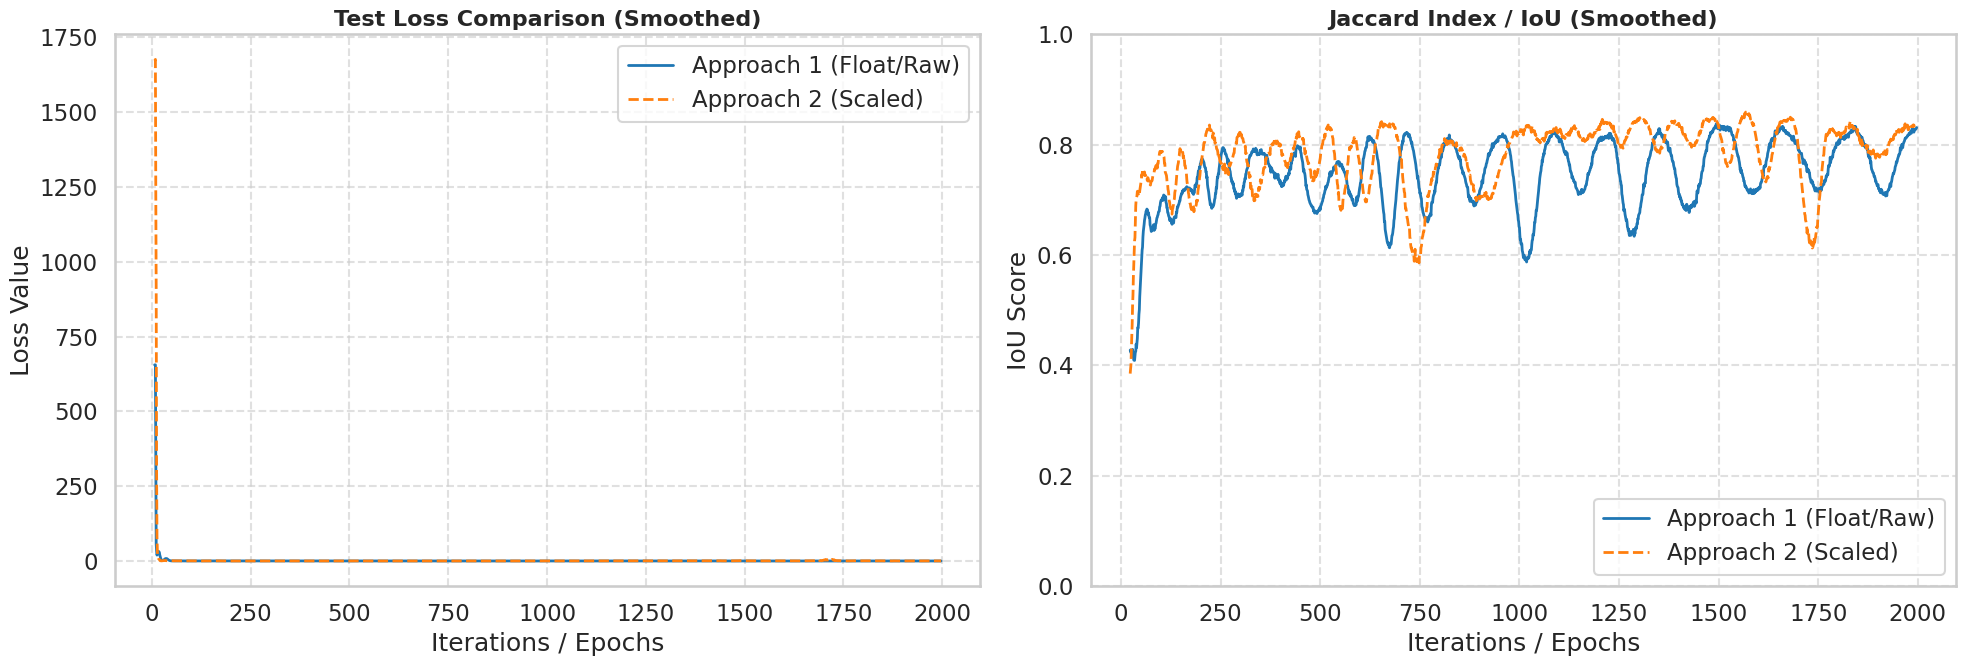

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but makes charts look much better instantly

# 1. Set a professional theme
sns.set_theme(style="whitegrid", context="talk")

f, axes = plt.subplots(1, 2, figsize=(20, 7))

# --- CHART 1: LOSS COMPARISON ---
# We use distinct colors and a slightly thicker line for visibility
axes[0].plot(flt_df['test_loss'].rolling(window=8).mean(),
             label='Approach 1 (Float/Raw)', color='#1f77b4', linewidth=2)
axes[0].plot(scaled_df['test_loss'].rolling(window=8).mean(),
             label='Approach 2 (Scaled)', color='#ff7f0e', linewidth=2, linestyle='--')

# Styling the Loss Chart
axes[0].set_title("Test Loss Comparison (Smoothed)", fontsize=16, weight='bold')
axes[0].set_ylabel("Loss Value")
axes[0].set_xlabel("Iterations / Epochs")
axes[0].legend(frameon=True)
axes[0].grid(True, linestyle='--', alpha=0.6)


# --- CHART 2: IoU COMPARISON ---
axes[1].plot(flt_df['test_iou'].rolling(window=24).mean(),
             label='Approach 1 (Float/Raw)', color='#1f77b4', linewidth=2)
axes[1].plot(scaled_df['test_iou'].rolling(window=24).mean(),
             label='Approach 2 (Scaled)', color='#ff7f0e', linewidth=2, linestyle='--')

# Styling the IoU Chart
axes[1].set_title("Jaccard Index / IoU (Smoothed)", fontsize=16, weight='bold')
axes[1].set_ylabel("IoU Score")
axes[1].set_xlabel("Iterations / Epochs")
axes[1].set_ylim(0, 1.0)  # Crucial: Locks the view to the valid 0-1 range
axes[1].legend(loc='lower right', frameon=True)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

- There exist a trade-off in here when we try to put we

In [ ]:
torch.save(flt_model.state_dict(), '/content/drive/MyDrive/EarthEngine/model/path.pth')